# NYC Data Feature Engineering

In [1]:
# !pip install s2sphere
# !pip install mapsplotlib

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler
import s2sphere

## Connect

In [2]:
conf = SparkConf().setAppName("msds697_project")
sc = SparkContext(conf=conf)
sc.setLogLevel("OFF")

In [3]:
ss = SparkSession.builder.getOrCreate()

## Import data and preprocess

In [4]:
def toFloatSafe(v):
    try:
        return float(v)
    except ValueError:
        return v

In [5]:
nyc_header = "vendor_name, Trip_Pickup_DateTime, Trip_Dropoff_DateTime,\
              Passenger_Count, Trip_Distance, Start_Lon, Start_Lat,\
              Rate_Code, store_and_forward, End_Lon, End_Lat, Payment_Type,\
              Fare_Amt, surcharge, mta_tax, Tip_Amt, Tolls_Amt, Total_Amt".split(",")

nyc_data = sc.textFile("data/nyc_data.csv")\
             .map(lambda x:  x.split(","))\
             .filter(lambda x: (len(x) == len(nyc_header)) & (x != nyc_header))\
             .map(lambda x: [toFloatSafe(v) for v in x])

### Clean Outside City Data

In [6]:
NY_lat_min = 40.70
NY_lat_max = 40.87
NY_long_max = -73.92
NY_long_min = -74.00

nyc_data = nyc_data.filter(lambda x: (x[10] >= NY_lat_min) & (x[10] <= NY_lat_max))\
                   .filter(lambda x: (x[6] >= NY_lat_min) & (x[6] <= NY_lat_max))\
                   .filter(lambda x: (x[5] >= NY_long_min) & (x[5] <= NY_long_max))\
                   .filter(lambda x: (x[9] >= NY_long_min) & (x[9] <= NY_long_max))

In [7]:
keep_cols = ['trip_pickup_datetime',
             'trip_dropoff_datetime',
             'trip_distance',
             'start_lon',
             'start_lat',
             'end_lon',
             'end_lat']

nyc_df = nyc_data.toDF([x.lower() for x in nyc_header])
nyc_df = nyc_df.select(keep_cols)

In [9]:
nyc_df.printSchema()

root
 |-- trip_pickup_datetime: string (nullable = true)
 |-- trip_dropoff_datetime: string (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- start_lon: double (nullable = true)
 |-- start_lat: double (nullable = true)
 |-- end_lon: double (nullable = true)
 |-- end_lat: double (nullable = true)



In [10]:
nyc_df.take(5)

[Row(trip_pickup_datetime='2009-01-04 03:31:00', trip_dropoff_datetime='2009-01-04 03:38:00', trip_distance=4.55, start_lon=-73.982102, start_lat=40.73629, end_lon=-73.95585, end_lat=40.76803),
 Row(trip_pickup_datetime='2009-01-01 20:52:58', trip_dropoff_datetime='2009-01-01 21:14:00', trip_distance=5.0, start_lon=-73.974267, start_lat=40.790955, end_lon=-73.996558, end_lat=40.731849),
 Row(trip_pickup_datetime='2009-01-16 22:35:59', trip_dropoff_datetime='2009-01-16 22:43:35', trip_distance=1.2, start_lon=-73.989806, start_lat=40.735006, end_lon=-73.985021, end_lat=40.724494),
 Row(trip_pickup_datetime='2009-01-21 08:55:57', trip_dropoff_datetime='2009-01-21 09:05:42', trip_distance=0.4, start_lon=-73.98405, start_lat=40.743544, end_lon=-73.98026, end_lat=40.748926),
 Row(trip_pickup_datetime='2009-01-04 04:31:00', trip_dropoff_datetime='2009-01-04 04:36:00', trip_distance=1.72, start_lon=-73.992635, start_lat=40.748362, end_lon=-73.995585, end_lat=40.728307)]

In [8]:
import matplotlib.pyplot as plt

In [ ]:
# nyc_pydf = nyc_df.toPandas()
# Error:java.lang.OutOfMemoryError: GC overhead limit exceeded

In [ ]:
# fig, ax = plt.subplots(ncols=1, nrows=1)
# ax.scatter(sf_data.long_x, sf_data.lat_x, s=10, lw=0, alpha=0.8)
# ax.set_xlim(SF_long_min, SF_long_max)
# ax.set_ylim(SF_lat_min, SF_lat_max)
# ax.set_xlabel("Longitude")
# ax.set_ylabel("Latitude")
# plt.show()

In [ ]:
# fig, ax = plt.subplots(ncols=1, nrows=1)
# ax.scatter(sf_data.long_y, sf_data.lat_y, s=10, lw=0, alpha=0.8)
# ax.set_xlim(SF_long_min, SF_long_max)
# ax.set_ylim(SF_lat_min, SF_lat_max)
# ax.set_xlabel("Longitude")
# ax.set_ylabel("Latitude")
# plt.show()

## Trip-level features

In [11]:
def lowercase_cols(df):
    for col in df.columns:
        new_col = col.lower()
        if new_col != col:
            df = df.withColumnRenamed(col, new_col)
    return df

def toDatetime(df, col_name):
    df = df.withColumn(col_name + "_2", to_timestamp(df[col_name], 'yyyy-MM-dd HH:mm:ss'))
    df = df.drop(col_name).withColumnRenamed(col_name + "_2", col_name)
    return df

nyc_df = lowercase_cols(nyc_df)

Extract day of week, add "is_weekend" flag when trip starts OR ends during the weekend

In [12]:
cell_level = 13

def coord_to_id_fun(x, cell_level=cell_level):
    lat, lon = x
    from s2sphere import CellId, LatLng
    cell_id = CellId.from_lat_lng(LatLng.from_degrees(lat, lon))\
    .parent(cell_level).to_token()
    return cell_id

def get_corners(s2CellId_str, cell_level=cell_level+1, cluster=1):
    from s2sphere import CellId, LatLng, Cell
    c1 = Cell(CellId(int(s2CellId_str,16)<<(60 - 2*cell_level)))
    v0 = LatLng.from_point(c1.get_vertex(0)) # lat/lon of upper/left corner
    v1 = LatLng.from_point(c1.get_vertex(1)) # lat/lon of lower/left corner
    v2 = LatLng.from_point(c1.get_vertex(2)) # lat/lon of lower/right corner
    v3 = LatLng.from_point(c1.get_vertex(3)) # lat/lon of upper/right corner
    return ((v0.lat().degrees, v0.lng().degrees, cluster),
            (v1.lat().degrees, v1.lng().degrees, cluster),
            (v2.lat().degrees, v2.lng().degrees, cluster),
            (v3.lat().degrees, v3.lng().degrees, cluster))

def distance_fun(x):
    import math
    lat1, lon1, lat2, lon2 = x
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c
    return d

coord_to_id = udf(lambda x: coord_to_id_fun(x), StringType())
distance = udf(lambda x: distance_fun(x), FloatType())

In [13]:
from pyspark.sql import functions as F

def process_features(df):
    df = toDatetime(df, "trip_pickup_datetime")
    df = toDatetime(df, "trip_dropoff_datetime")

    df = df.withColumn('dow_dropoff', date_format('trip_dropoff_datetime', 'u').cast(IntegerType()))\
           .withColumn('strdow_dropoff', date_format('trip_dropoff_datetime', 'E'))\
           .withColumn('dow_pickup', date_format('trip_pickup_datetime', 'u').cast(IntegerType()))\
           .withColumn('strdow_pickup', date_format('trip_pickup_datetime', 'E'))\
           .withColumn('hour_pickup', date_format('trip_pickup_datetime', 'H').cast(IntegerType()))\
           .withColumn('hour_dropoff', date_format('trip_dropoff_datetime', 'H').cast(IntegerType()))

    df = df.withColumn("is_weekend", when((df.dow_pickup >= 6) | (df.dow_dropoff >= 6), 1).otherwise(0))

    df = df.withColumn("start_cell_id", coord_to_id(array("start_lat", "start_lon")))
    df = df.withColumn("end_cell_id", coord_to_id(array("end_lat", "end_lon")))
    df = df.withColumn("distance_km", distance(array("start_lat", "start_lon","end_lat", "end_lon")))


    timeFmt = "yyyy-MM-dd HH:mm:ss"
    timediff = (F.unix_timestamp('trip_dropoff_datetime', format=timeFmt)
                - F.unix_timestamp('trip_pickup_datetime', format=timeFmt))
    df = df.withColumn("trip_duration", timediff)

    return df

In [14]:
nyc_df = process_features(nyc_df)
nyc_df.cache()

DataFrame[trip_distance: double, start_lon: double, start_lat: double, end_lon: double, end_lat: double, trip_pickup_datetime: timestamp, trip_dropoff_datetime: timestamp, dow_dropoff: int, strdow_dropoff: string, dow_pickup: int, strdow_pickup: string, hour_pickup: int, hour_dropoff: int, is_weekend: int, start_cell_id: string, end_cell_id: string, distance_km: float, trip_duration: bigint]

### Clean Unreasonable Trips

In [ ]:
nyc_df.approxQuantile("trip_duration", [.0], 0)

In [ ]:
nyc_df.approxQuantile("trip_duration", [0.01], 0)

In [ ]:
nyc_df.approxQuantile("trip_duration", [0.99], 0)

In [ ]:
nyc_df.approxQuantile("trip_duration", [1.], 0)

In [15]:
nyc_df = nyc_df.filter(nyc_df.trip_duration <= 1800)\
               .filter(nyc_df.trip_duration >= 30)

In [17]:
nyc_df.rdd.saveAsPickleFile("nyc_df_trip_level_cleaned")

In [16]:
temp = nyc_df.withColumn("factor", nyc_df.trip_distance/nyc_df.distance_km)
nyc_factor = temp.agg(avg(temp.factor).alias('factor'))
nyc_factor = nyc_factor.toPandas()
nyc_factor = nyc_factor.factor[0]
nyc_factor

1.9459790624386955

## Cell-level Features

### Divide areas into cells

In [ ]:
pickleRdd = sc.pickleFile("nyc_df_trip_level_cleaned").collect()
nyc_df = sc.createDataFrame(pickleRdd)

In [36]:
nyc_df = nyc_df.withColumn("start_cell_id", coord_to_id(array("start_lat", "start_lon")))
nyc_df = nyc_df.withColumn("end_cell_id", coord_to_id(array("end_lat", "end_lon")))
nyc_df = nyc_df.withColumn("distance_km", distance(array("start_lat", "start_lon","end_lat", "end_lon")))
nyc_df.cache()

DataFrame[trip_distance: double, start_lon: double, start_lat: double, end_lon: double, end_lat: double, trip_pickup_datetime: timestamp, trip_dropoff_datetime: timestamp, dow_dropoff: int, strdow_dropoff: string, dow_pickup: int, strdow_pickup: string, hour_pickup: int, hour_dropoff: int, is_weekend: int, start_cell_id: string, end_cell_id: string, distance_km: float, trip_duration: bigint]

In [37]:
%%time
nyc_df.count()

CPU times: user 8.25 ms, sys: 4.86 ms, total: 13.1 ms
Wall time: 1min 34s


9496877

### Gather features by cell

In [38]:
def pivot_column(df, group_col, pv_col, prefix):
    orig_cols = set(df.columns)
    new_df = df.groupBy(group_col).pivot(pv_col).count()
    new_cols = new_df.columns
    new_cols = [c if c in orig_cols else prefix + c for c in new_cols]
    new_df = new_df.toDF(*new_cols)
    new_df = new_df.na.fill(0, list(set(new_cols) - orig_cols))
    return new_df

In [39]:
def merge_dfs(dfs):
    first_df = None
    for df in dfs:
        if first_df is None:
            first_df = df
        else:
            first_df = first_df.join(df, "cell_id", "left_outer")
    return first_df

In [40]:
def create_features(df):
    dow_pickup_df = pivot_column(df, group_col = "start_cell_id", 
                                     pv_col = "dow_pickup", prefix = "dow_pickup_")\
                                     .withColumnRenamed("start_cell_id", "cell_id")

    dow_dropoff_df = pivot_column(df, group_col = "end_cell_id", 
                                      pv_col = "dow_dropoff", prefix = "dow_dropoff_")\
                                      .withColumnRenamed("end_cell_id", "cell_id")

    hr_pickup_wkday_df = pivot_column(df.filter(df.dow_pickup<6), 
                                                               group_col = "start_cell_id", 
                                                               pv_col = "hour_pickup", 
                                                               prefix = "hr_pickup_wkday")\
                                                               .withColumnRenamed("start_cell_id", "cell_id")

    hr_dropoff_wkday_df = pivot_column(df.filter(df.dow_dropoff<6), 
                                                               group_col = "end_cell_id", 
                                                               pv_col = "hour_dropoff", 
                                                               prefix = "hr_dropoff_wkday")\
                                                               .withColumnRenamed("end_cell_id", "cell_id")

    hr_pickup_wkend_df = pivot_column(df.filter(df.dow_pickup>=6), 
                                                               group_col = "start_cell_id", 
                                                               pv_col = "hour_pickup", 
                                                               prefix = "hr_pickup_wkend")\
                                                               .withColumnRenamed("start_cell_id", "cell_id")

    hr_dropoff_wkend_df = pivot_column(df.filter(df.dow_dropoff>=6), 
                                                               group_col = "end_cell_id", 
                                                               pv_col = "hour_dropoff", 
                                                               prefix = "hr_dropoff_wkend")\
                                                               .withColumnRenamed("end_cell_id", "cell_id")

    pickup_km_df = df.groupBy("start_cell_id").agg(avg("distance_km"),stddev("distance_km"))\
                        .withColumnRenamed("avg(distance_km)", "avg_pickup_km")\
                        .withColumnRenamed("stddev_samp(distance_km)", "std_pickup_km")\
                        .withColumnRenamed("start_cell_id", "cell_id")

    dropoff_km_df = df.groupBy("end_cell_id").agg(avg("distance_km"),stddev("distance_km"))\
                        .withColumnRenamed("avg(distance_km)", "avg_dropoff_km")\
                        .withColumnRenamed("stddev_samp(distance_km)", "std_dropoff_km")\
                        .withColumnRenamed("end_cell_id", "cell_id")
    
    discrete_pickup_cell_no = df.groupBy("end_cell_id")\
                                .agg(countDistinct("start_cell_id").alias("discrete_pickup_cell_no"))\
                                .withColumnRenamed("end_cell_id", "cell_id")
    
    discrete_dropoff_cell_no = df.groupBy("start_cell_id")\
                                .agg(countDistinct("end_cell_id").alias("discrete_dropoff_cell_no"))\
                                .withColumnRenamed("start_cell_id", "cell_id")

    cell_df = merge_dfs([dow_pickup_df, dow_dropoff_df, 
              hr_pickup_wkday_df, hr_dropoff_wkday_df,
              hr_pickup_wkend_df, hr_dropoff_wkend_df,
              pickup_km_df, dropoff_km_df,
              discrete_pickup_cell_no, discrete_dropoff_cell_no
             ])

    cell_df = cell_df.na.fill(0)

    cell_df.printSchema()
    
    feature_columns = [c for c in cell_df.columns if c != "cell_id"]

    for c in feature_columns:
        cell_df = cell_df.withColumn(c+"_f", cell_df[c].cast(FloatType()))
        cell_df = cell_df.drop(c)
        cell_df = cell_df.withColumnRenamed(c+"_f",c)

    cell_df.cache()

    print(cell_df.count(), len(cell_df.columns))

    return cell_df

In [41]:
nyc_cell_df = create_features(nyc_df)
nyc_cell_df.cache()

root
 |-- cell_id: string (nullable = true)
 |-- dow_pickup_1: long (nullable = true)
 |-- dow_pickup_2: long (nullable = true)
 |-- dow_pickup_3: long (nullable = true)
 |-- dow_pickup_4: long (nullable = true)
 |-- dow_pickup_5: long (nullable = true)
 |-- dow_pickup_6: long (nullable = true)
 |-- dow_pickup_7: long (nullable = true)
 |-- dow_dropoff_1: long (nullable = true)
 |-- dow_dropoff_2: long (nullable = true)
 |-- dow_dropoff_3: long (nullable = true)
 |-- dow_dropoff_4: long (nullable = true)
 |-- dow_dropoff_5: long (nullable = true)
 |-- dow_dropoff_6: long (nullable = true)
 |-- dow_dropoff_7: long (nullable = true)
 |-- hr_pickup_wkday0: long (nullable = true)
 |-- hr_pickup_wkday1: long (nullable = true)
 |-- hr_pickup_wkday2: long (nullable = true)
 |-- hr_pickup_wkday3: long (nullable = true)
 |-- hr_pickup_wkday4: long (nullable = true)
 |-- hr_pickup_wkday5: long (nullable = true)
 |-- hr_pickup_wkday6: long (nullable = true)
 |-- hr_pickup_wkday7: long (nullable =

DataFrame[cell_id: string, dow_pickup_1: float, dow_pickup_2: float, dow_pickup_3: float, dow_pickup_4: float, dow_pickup_5: float, dow_pickup_6: float, dow_pickup_7: float, dow_dropoff_1: float, dow_dropoff_2: float, dow_dropoff_3: float, dow_dropoff_4: float, dow_dropoff_5: float, dow_dropoff_6: float, dow_dropoff_7: float, hr_pickup_wkday0: float, hr_pickup_wkday1: float, hr_pickup_wkday2: float, hr_pickup_wkday3: float, hr_pickup_wkday4: float, hr_pickup_wkday5: float, hr_pickup_wkday6: float, hr_pickup_wkday7: float, hr_pickup_wkday8: float, hr_pickup_wkday9: float, hr_pickup_wkday10: float, hr_pickup_wkday11: float, hr_pickup_wkday12: float, hr_pickup_wkday13: float, hr_pickup_wkday14: float, hr_pickup_wkday15: float, hr_pickup_wkday16: float, hr_pickup_wkday17: float, hr_pickup_wkday18: float, hr_pickup_wkday19: float, hr_pickup_wkday20: float, hr_pickup_wkday21: float, hr_pickup_wkday22: float, hr_pickup_wkday23: float, hr_dropoff_wkday0: float, hr_dropoff_wkday1: float, hr_dro

In [42]:
(nyc_cell_df.count(), len(nyc_cell_df.columns))

(144, 117)

In [43]:
nyc_cell_df.rdd.saveAsPickleFile("nyc_df_cell_level")

## Vectorize features

In [ ]:
pickleRdd = sc.pickleFile("nyc_df_cell_level").collect()
nyc_df = sc.createDataFrame(pickleRdd)

In [238]:
from pyspark.ml.feature import StandardScaler

def vectorize(cell_df, city):
    feature_columns = [c for c in cell_df.columns if c != "cell_id"]
    va = VectorAssembler(outputCol="features", inputCols=feature_columns)
    vectorized_df = va.transform(cell_df)
    vectorized_df = vectorized_df.select("features")

    scaler = StandardScaler(inputCol="features",\
             outputCol="scaledFeatures")
    scalerModel =  scaler.fit(vectorized_df)
    vectorized_df = scalerModel.transform(vectorized_df)
    
    vectorized_df = vectorized_df.withColumn('row_index', monotonically_increasing_id())
    cell_df = cell_df.withColumn('row_index', monotonically_increasing_id())
    vectorized_df = vectorized_df.join(cell_df.select("row_index", "cell_id"), on=["row_index"]).sort("row_index").drop("row_index")
    vectorized_df = vectorized_df.withColumn("city", lit(city))

    return vectorized_df

In [239]:
%%time
nyc_vectorized_df = vectorize(nyc_cell_df, city="NY")
nyc_vectorized_df.cache()
nyc_vectorized_df.count()

CPU times: user 20 ms, sys: 8 ms, total: 28 ms
Wall time: 12.8 s


In [240]:
nyc_vectorized_df.show(2)

+--------------------+--------------------+--------+----+
|            features|      scaledFeatures| cell_id|city|
+--------------------+--------------------+--------+----+
|(114,[5,82,110],[...|(114,[5,82,110],[...|87e9702c|  NY|
|(114,[5,83,110],[...|(114,[5,83,110],[...|89b1105c|  NY|
+--------------------+--------------------+--------+----+
only showing top 2 rows



## Plotting

### Common outbound cells

In [325]:
nyc_popular_cell_id = nyc_df.groupBy("end_cell_id").count().orderBy("count", ascending=False).first().end_cell_id
nyc_unpopular_cell_id = nyc_df.groupBy("end_cell_id").count().orderBy("count", ascending=True).first().end_cell_id

In [83]:
%matplotlib inline

import pandas as pd
import numpy as np
from mapsplotlib import mapsplot as mplt
import constants as c
mplt.register_api_key(c.google_maps_key)

def show_cell(cell_id, cell_level=cell_level+1):
    map_data = get_corners(cell_id, cell_level=14)
    map_df = pd.DataFrame(np.array(map_data), columns=["latitude", "longitude", "cluster"])
    map_df.cluster = map_df.cluster.astype(np.int)
    mplt.polygons(map_df['latitude'], map_df['longitude'], map_df['cluster'])

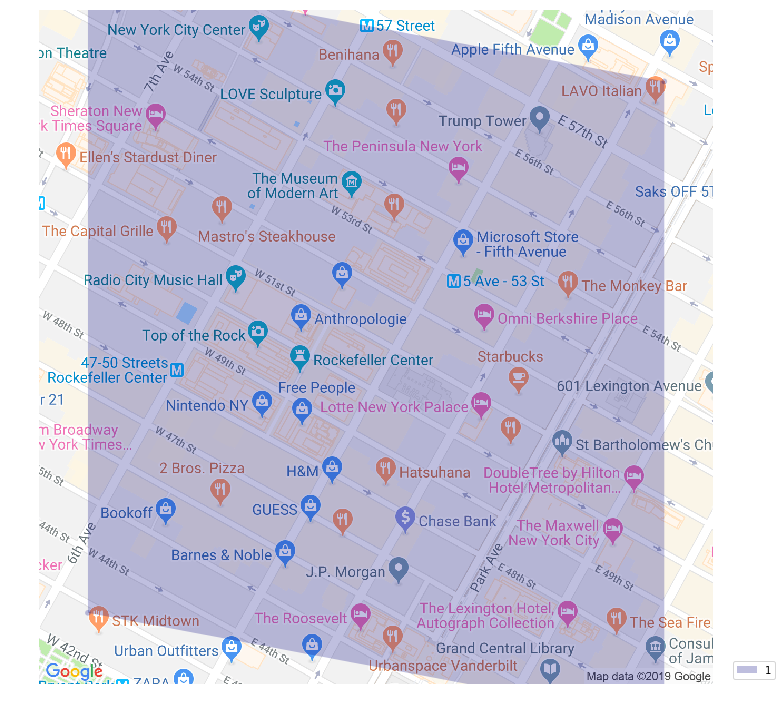

In [100]:
show_cell(popular_cell_id)

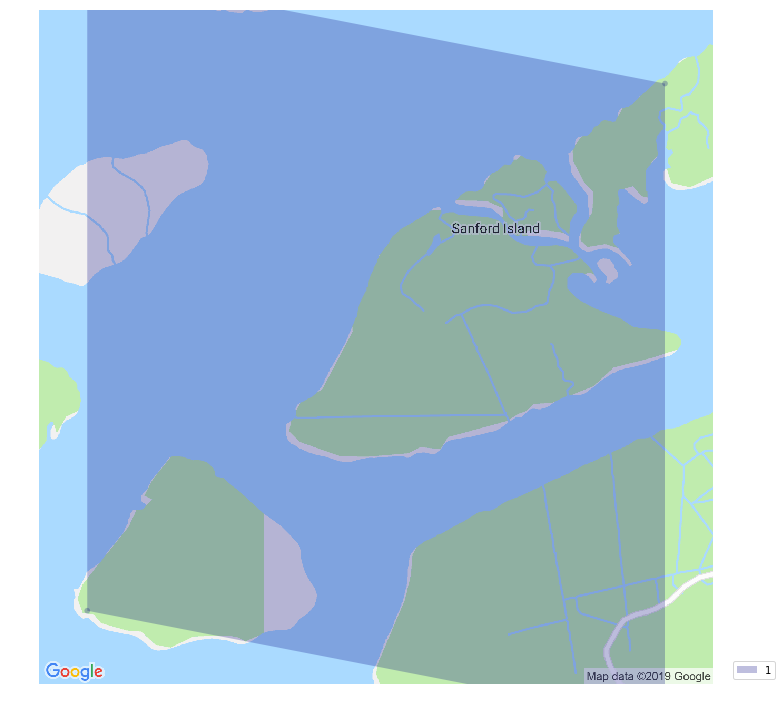

In [85]:
show_cell(unpopular_cell_id)